<a href="https://colab.research.google.com/github/adityanandy2802/ml-dl-task/blob/main/SRIP_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Gpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 KB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Gpy: filename=GPy-1.10.0-cp39-cp39-linux_x86_64.whl size=3288018 sha256=713f9628c9a7acd96661183a080569bdf83a9c7d1a7c77f535720c46a195f9ab
  Stored in directory: /root/.cache/pip/wheels/78/fd/57/7c1e4a6f9a5380e2536af9809075ba085b1bb8d38ee84ea183
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=d1b0aeff3807354937cd39e281a5f2b4e03c6d65ef3d772e79b4f550415c7ead
  Stored in directory: /root/.cache/pip/wheels/9c/5f/9b/c4273ae8f869387214be2b99598d1b71dbf00672576cb85e74
Successfully built Gpy paramz


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import GPy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

### Extracting Data

Reading the data using `pd.read_csv` method

In [ ]:
data=pd.read_csv('/content/openaq.csv')
data.dropna()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,attribution
0,US Diplomatic Post: Chennai,Chennai,IN,2018-05-31T18:30:00.000Z,2018-06-01T00:00:00+05:30,pm25,23.00,µg/m³,13.087840,80.278470,"[{""name"":""EPA AirNow DOS"",""url"":""http://airnow..."
1,US Diplomatic Post: Mumbai,Mumbai,IN,2018-05-31T18:30:00.000Z,2018-06-01T00:00:00+05:30,pm25,36.00,µg/m³,19.072830,72.882610,"[{""name"":""EPA AirNow DOS"",""url"":""http://airnow..."
2,Maharashtra Pollution Control Board - Solapur,Solapur,IN,2018-05-31T18:30:00.000Z,2018-06-01T00:00:00+05:30,pm10,67.66,µg/m³,17.659919,75.906391,"[{""name"":""Central Pollution Control Board"",""ur..."
3,US Diplomatic Post: New Delhi,Delhi,IN,2018-05-31T18:30:00.000Z,2018-06-01T00:00:00+05:30,pm25,59.00,µg/m³,28.635760,77.224450,"[{""name"":""EPA AirNow DOS"",""url"":""http://airnow..."
4,US Diplomatic Post: Kolkata,Kolkata,IN,2018-05-31T18:30:00.000Z,2018-06-01T00:00:00+05:30,pm25,31.00,µg/m³,22.562630,88.363040,"[{""name"":""EPA AirNow DOS"",""url"":""http://airnow..."
...,...,...,...,...,...,...,...,...,...,...,...
65531,"Ward-32 Bapupara, Siliguri - WBPCB",Siliguri,IN,2018-05-07T17:30:00.000Z,2018-05-07T23:00:00+05:30,pm10,85.99,µg/m³,26.688305,88.412668,"[{""name"":""Central Pollution Control Board"",""ur..."
65532,"Padmapukur, Howrah - WBPCB",Howrah,IN,2018-05-07T17:30:00.000Z,2018-05-07T23:00:00+05:30,pm10,66.52,µg/m³,22.568732,88.279728,"[{""name"":""Central Pollution Control Board"",""ur..."
65533,"Manali, Chennai - CPCB",Chennai,IN,2018-05-07T17:30:00.000Z,2018-05-07T23:00:00+05:30,pm25,31.05,µg/m³,13.164544,80.262850,"[{""name"":""Central Pollution Control Board"",""ur..."
65534,"Shastri Nagar, Jaipur - RSPCB",Jaipur,IN,2018-05-07T17:30:00.000Z,2018-05-07T23:00:00+05:30,pm10,202.96,µg/m³,26.950293,75.730943,"[{""name"":""Central Pollution Control Board"",""ur..."


We will use only the 1st column `city`, `utc` and `value` for our forecasting.

In [ ]:
df=pd.read_csv("/content/openaq.csv", usecols=[1,3,6])

`utc` must be inferred as date time. So we do the required conversion.

In [ ]:
df["utc"]=pd.to_datetime(df["utc"], infer_datetime_format=True)

We cluster only the values of Delhi out of the dataset.

In [ ]:
delhi=df.loc[df["city"]=="Delhi"]

After this we don't need city name because it is unncessary. Hence it is dropped

In [ ]:
delhi=delhi.drop(["city"], axis=1)
delhi2=delhi.set_index(["utc"])
delhi2

,value
utc,
2018-05-31 18:30:00+00:00,59.00
2018-05-31 17:30:00+00:00,61.00
2018-05-31 16:30:00+00:00,65.00
2018-05-31 15:30:00+00:00,63.00
2018-05-31 14:30:00+00:00,58.00
...,...
2018-05-07 17:45:00+00:00,439.00
2018-05-07 17:45:00+00:00,395.24
2018-05-07 17:45:00+00:00,140.90


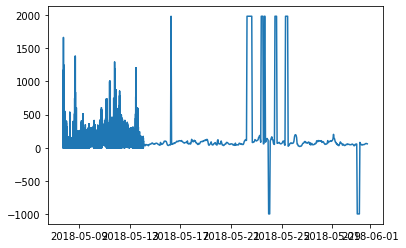

In [ ]:
plt.plot(delhi2)

#### We can see `negative` values of PM2.5 and some value which is not possible. Hence we need to take care of them

In [ ]:
delhi2=delhi2.loc[delhi2["value"]>0]
delhi2=delhi2.loc[delhi2["value"]<500]
delhi=delhi.loc[delhi["value"]>0]
delhi=delhi.loc[delhi["value"]<500]

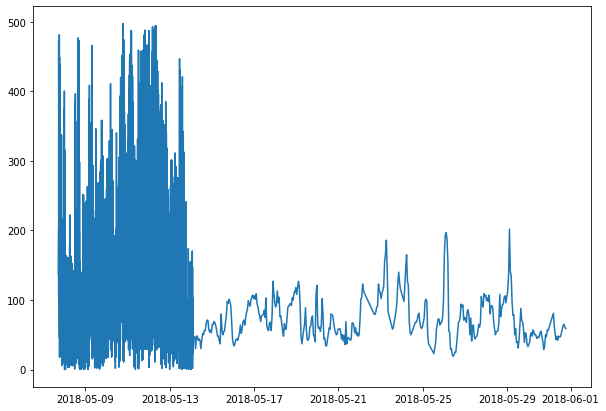

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(delhi["utc"],delhi["value"])
plt.show()

### Train Data (One Week)

We choose a week to train our time series forecasting data on.

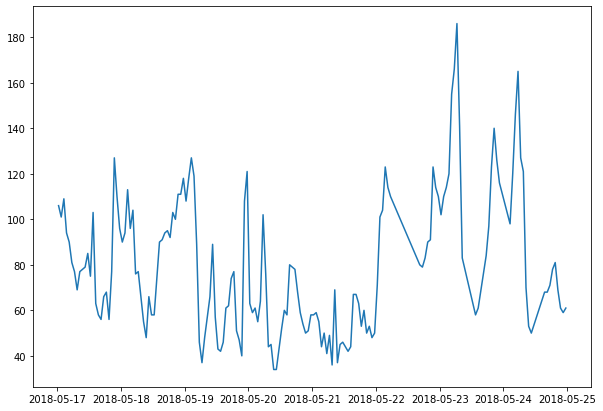

In [ ]:
mask = (delhi['utc'] > '2018-05-17') & (delhi['utc'] <= '2018-05-25')
delhi_one_week=delhi.loc[mask]
plt.figure(figsize=(10,7))
plt.plot(delhi_one_week["utc"], delhi_one_week["value"])
plt.show()

Here, what we do is we will take the last 6 hrs of data and we will interpolate based on that.

In [ ]:
delhi_one_week['value_1hr_back']=delhi_one_week['value'].shift(+1)
delhi_one_week['value_2hr_back']=delhi_one_week['value'].shift(+2)
delhi_one_week['value_3hr_back']=delhi_one_week['value'].shift(+3)
delhi_one_week['value_4hr_back']=delhi_one_week['value'].shift(+4)
delhi_one_week['value_5hr_back']=delhi_one_week['value'].shift(+5)
delhi_one_week['value_6hr_back']=delhi_one_week['value'].shift(+6)
delhi_one_week=delhi_one_week.dropna()

We finally create our train set

In [ ]:
x1,x2,x3,x4,x5,x6=delhi_one_week["value_1hr_back"],delhi_one_week["value_2hr_back"],delhi_one_week["value_3hr_back"],delhi_one_week["value_4hr_back"],delhi_one_week["value_5hr_back"],delhi_one_week["value_6hr_back"]
x1,x2,x3,x4,x5,x6=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6)
x1,x2,x3,x4,x5,x6=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1)
x_train=np.concatenate((x1,x2,x3,x4,x5,x6),axis=1)

In [ ]:
y_train=np.array(delhi_one_week["value"])

### Test Data

Test set is created similarly. The test set will be for the rest of the month (from `2018-05-25` to the end of May)

In [ ]:
delhi_pred=delhi.loc[delhi["utc"]>'2018-05-25']
delhi_pred['value_1hr_back']=delhi_pred['value'].shift(+1)
delhi_pred['value_2hr_back']=delhi_pred['value'].shift(+2)
delhi_pred['value_3hr_back']=delhi_pred['value'].shift(+3)
delhi_pred['value_4hr_back']=delhi_pred['value'].shift(+4)
delhi_pred['value_5hr_back']=delhi_pred['value'].shift(+5)
delhi_pred['value_6hr_back']=delhi_pred['value'].shift(+6)
delhi_pred=delhi_pred.dropna()

x_test1,x_test2,x_test3,x_test4,x_test5,x_test6=delhi_pred["value_1hr_back"],delhi_pred["value_2hr_back"],delhi_pred["value_3hr_back"],delhi_pred["value_4hr_back"],delhi_pred["value_5hr_back"],delhi_pred["value_6hr_back"]
x_test1,x_test2,x_test3,x_test4,x_test5,x_test6=np.array(x_test1),np.array(x_test2),np.array(x_test3),np.array(x_test4),np.array(x_test5),np.array(x_test6)
x_test1,x_test2,x_test3,x_test4,x_test5,x_test6=x_test1.reshape(-1,1),x_test2.reshape(-1,1),x_test3.reshape(-1,1),x_test4.reshape(-1,1),x_test5.reshape(-1,1),x_test6.reshape(-1,1)
x_test=np.concatenate((x_test1,x_test2,x_test3,x_test4,x_test5,x_test6),axis=1)

Plot of the test set.

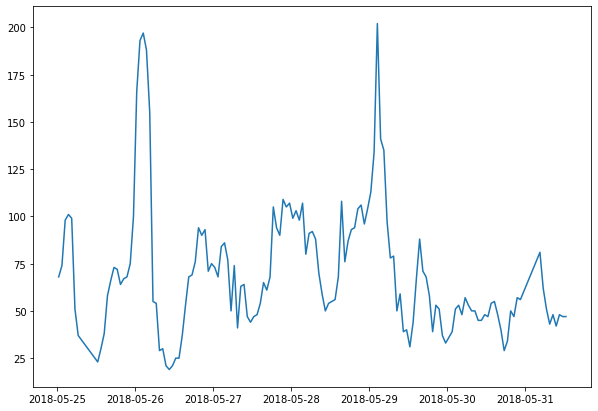

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(delhi_pred["utc"], delhi_pred["value"])
plt.show()

### Plot Fit

Function to plot our data

In [ ]:
def plot(method, delhi_one_week, x_train, y_train, label):
  model=method.fit(x_train,y_train)
  plt.figure(figsize=(10,7))
  plt.plot(delhi_one_week["utc"], delhi_one_week["value"], label="One week data")
  plt.plot(delhi_one_week["utc"],model.predict(x_train), label=label)
  plt.xlabel("Time")
  plt.ylabel("""PM2.5 conc ($\dfrac{\mu g}{m^3}$)""")
  plt.legend()
  plt.show()

Function to plot predictions alongside data

In [ ]:
def plot_predict(method,x_train, y_train, delhi_pred, x_test, label):
  model=method.fit(x_train,y_train)
  predictions=model.predict(x_test)
  plt.figure(figsize=(10,7))
  plt.plot(delhi_pred["utc"], delhi_pred["value"], label="Real Data")
  plt.plot(delhi_pred["utc"], predictions, label=label)
  plt.xlabel("Time")
  plt.ylabel("""PM2.5 conc ($\dfrac{\mu g}{m^3}$)""")
  plt.legend()
  plt.show()

### Linear Regression

In [ ]:
l_reg=LinearRegression()

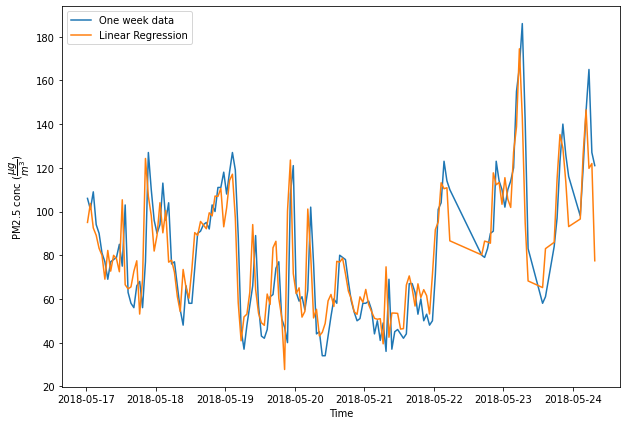

In [ ]:
plot(l_reg, delhi_one_week, x_train, y_train, "Linear Regression")

#### Testing

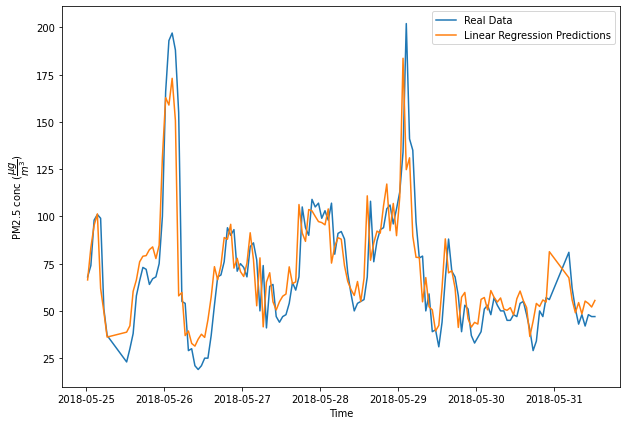

In [ ]:
plot_predict(l_reg, x_train, y_train, delhi_pred, x_test, "Linear Regression Predictions")

### Random Forest Regressor

In [ ]:
rf=RandomForestRegressor(n_estimators=1000,max_features=10)

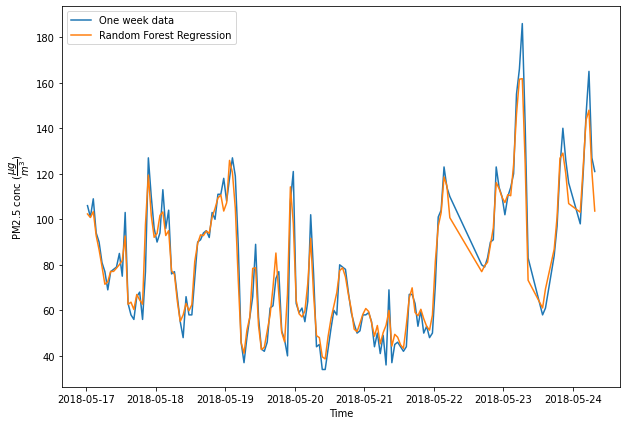

In [ ]:
plot(rf, delhi_one_week,x_train, y_train, "Random Forest Regression")

#### Testing

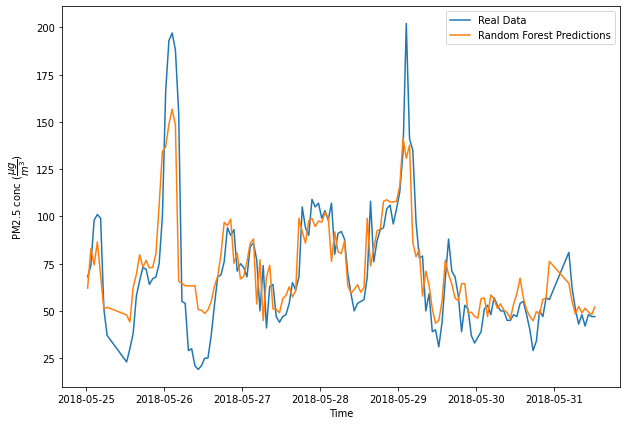

In [ ]:
plot_predict(rf, x_train, y_train, delhi_pred, x_test, "Random Forest Predictions")

### Gaussian Process Regressor

I learnt about the GPy module and its uses from this video: [Gaussian Process Regression Practical demo](https://www.youtube.com/watch?v=V1bF37-_ytQ&t=1112s)

In [ ]:
gauss_x_train=x_train
gauss_y_train=y_train.reshape(-1,1)

In [ ]:
k=GPy.kern.RBF(1)
model_gauss=GPy.models.GPRegression(gauss_x_train,gauss_y_train,k)
model_gauss.optimize()

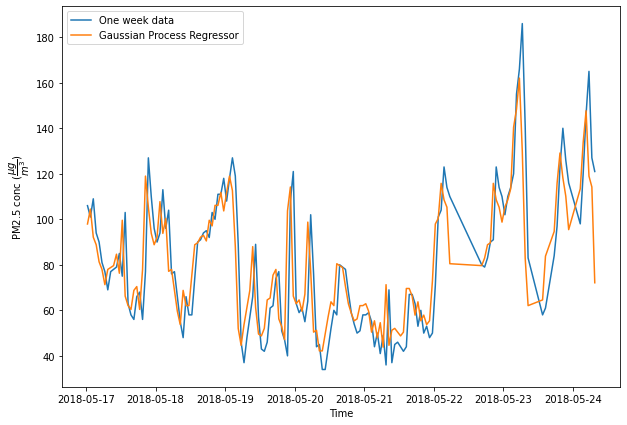

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(delhi_one_week["utc"], delhi_one_week["value"], label="One week data")
plt.plot(delhi_one_week["utc"],model_gauss.predict(gauss_x_train)[0], label="Gaussian Process Regressor")
plt.xlabel("Time")
plt.ylabel("""PM2.5 conc ($\dfrac{\mu g}{m^3}$)""")
plt.legend()
plt.show()

#### Testing

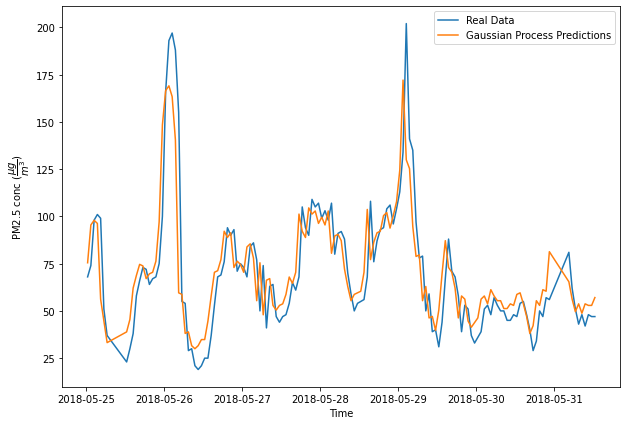

In [ ]:
predictions=model_gauss.predict(x_test)[0]
plt.figure(figsize=(10,7))
plt.plot(delhi_pred["utc"], delhi_pred["value"], label="Real Data")
plt.plot(delhi_pred["utc"], predictions, label="Gaussian Process Predictions")
plt.xlabel("Time")
plt.ylabel("""PM2.5 conc ($\dfrac{\mu g}{m^3}$)""")
plt.legend()
plt.show()

### KFold Cross Validation

We will apply KFold cross validation across all the abpve regression techniques. 
* We will split the dataset in groups of 10 and shuffle them.
* Our metric is Mean Squared Error (MSE)

In [ ]:
kf= KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
lreg_mse=[]
rf_mse=[]
gauss_mse=[]

In [ ]:
for train_index, test_index in kf.split(x_train):
  X_TRAIN, X_TEST, Y_TRAIN, Y_TEST= x_train[train_index], x_train[test_index], y_train[train_index], y_train[test_index]
  
  model_l_reg=l_reg.fit(X_TRAIN, Y_TRAIN)
  
  model_RF=rf.fit(X_TRAIN, Y_TRAIN)
  
  k=GPy.kern.RBF(1)
  model_Gauss=GPy.models.GPRegression(X_TRAIN,Y_TRAIN.reshape(-1,1),k)
  model_Gauss.optimize()

  lreg_mse.append(mean_squared_error(Y_TEST, model_l_reg.predict(X_TEST)))
  rf_mse.append(mean_squared_error(Y_TEST, model_RF.predict(X_TEST)))
  gauss_mse.append(mean_squared_error(Y_TEST, model_Gauss.predict(X_TEST)[0]))

mean_lreg_mse=np.mean(lreg_mse)
mean_rf_mse=np.mean(rf_mse)
mean_gauss_mse=np.mean(gauss_mse)

The mean MSE of the regression techniques are given below

In [ ]:
mean_lreg_mse, mean_rf_mse, mean_gauss_mse

(105.89169021006066, 125.66579211944867, 108.22926732819231)

The tabulated results of the cross validation

In [ ]:
mydata=[["MSE",mean_lreg_mse, mean_rf_mse, mean_gauss_mse]]
header=["Metric", "Linear Regression", "Random Forest Regression", "Gaussian Process Regression"]
print(tabulate(mydata, header, tablefmt="grid"))

+----------+---------------------+----------------------------+-------------------------------+
| Metric   |   Linear Regression |   Random Forest Regression |   Gaussian Process Regression |
+==========+=====================+============================+===============================+
| MSE      |             105.892 |                    125.666 |                       108.229 |
+----------+---------------------+----------------------------+-------------------------------+
